# 1️⃣ Introduction

## Emotion Classification Pipeline for Biblical Verses

This notebook documents the full process of exploring, comparing and fine-tuning emotion classification models on biblical text, with a focus on the Book of Genesis and a final fine-tuning using a custom-annotated corpus.

**Outline:**
1. Model Benchmarking on Genesis
2. Data Preparation for Fine-tuning
3. Semi-automatic Labeling using GPT-4o
4. Fine-tuning SamLowe/roberta-base-go_emotions
5. Evaluation and Comparison with Previous Models
6. Inference Examples and Analysis

---

**Project context:**  
Emotion and theme detection in Bible verses for narrative and literary research, using NLP and modern transformer models.


# 2️⃣ Benchmarking Pretrained Models on Genesis

## 1. Benchmarking Existing Models

We begin by testing several HuggingFace models (Hartmann, GoEmotions/SamLowe, Bhadresh Savani, Joeddav) on Genesis.  
The goal is to observe their behaviour on literary, ancient text before committing to any single approach.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/processed/bible_kjv/1_genesis_emotion_comparison.csv")
display(df.head())

# Plot emotion distributions
plt.figure()
sns.countplot(x="hartmann_label", data=df, order=df['hartmann_label'].value_counts().index)
plt.title("Hartmann Emotion Distribution")
plt.show()

plt.figure()
sns.countplot(x="goemotions_ekman_label", data=df, order=df['goemotions_ekman_label'].value_counts().index)
plt.title("GoEmotions (Ekman) Distribution")
plt.show()

plt.figure()
sns.countplot(x="bsavani_label", data=df, order=df['bsavani_label'].value_counts().index)
plt.title("Bhadresh Savani Emotion Distribution")
plt.show()

plt.figure()
sns.countplot(x="joeddav_ekman_label", data=df, order=df['joeddav_ekman_label'].value_counts().index)
plt.title("Joeddav (Ekman) Distribution")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/bible_kjv/1_genesis_emotion_comparison.csv'

### **Observations:**
- GoEmotions produces a strong "neutral" bias on Genesis.
- Hartmann and bsavani force more emotion categories, but may overfit to their social-media source.
- Joeddav shows a different distribution, with many "surprise" and "joy".
- None of the available models fit perfectly for literary or biblical style.


# 3️⃣ Preparing a Custom Dataset for Fine-tuning

## 2. Preparing a Custom Dataset for Fine-tuning

Given the above, we decided to build a custom, hand-verified emotion-labeled dataset, leveraging GPT-4o for fast annotation and manual review.
- 1000 unique verses were sampled from the full KJV.
- Each verse was labeled with one of: joy, sadness, anger, fear, disgust, surprise, neutral.


In [3]:
# Show sample of selected verses
df_samples = pd.read_csv("../data/evaluation/emotion_verses_to_label.csv")
display(df_samples.sample(5))
print(f"Total verses sampled: {len(df_samples)}")

,id,verse_id,verse
657,657,jeremiah_50_43,The king of Babylon hath heard the report of t...
488,488,deuteronomy_30_15,"See, I have set before thee this day life and ..."
520,520,luke_22_43,And there appeared an angel unto him from heav...
678,678,2_chronicles_2_1,And Solomon determined to build an house for t...
21,21,acts_11_18,"When they heard these things, they held their ..."


Total verses sampled: 1000


# 4️⃣ Labeling Verses with GPT-4o (Semi-automatic Annotation)

## 3. Semi-automatic Annotation using GPT-4o

Annotation prompt for GPT-4o:

> Assign ONE main human emotion to each Bible verse below.  
> Choose ONLY from this list: joy, sadness, anger, fear, disgust, surprise, neutral  
> Return in CSV format with columns: id,verse_id,label  
> [See appendix for full prompt.]

Labels were reviewed and corrected as needed before proceeding to fine-tuning.


,id,verse_id,verse,label
959,959,mark_1_12,And immediately the Spirit driveth him into th...,neutral
682,682,ezekiel_27_28,The suburbs shall shake at the sound of the cr...,fear
289,289,psalms_102_11,My days are like a shadow that declineth; and ...,sadness
786,786,genesis_31_11,"And the angel of God spake unto me in a dream,...",surprise
810,810,acts_9_24,But their laying await was known of Saul. And ...,fear


Total labeled verses: 1000


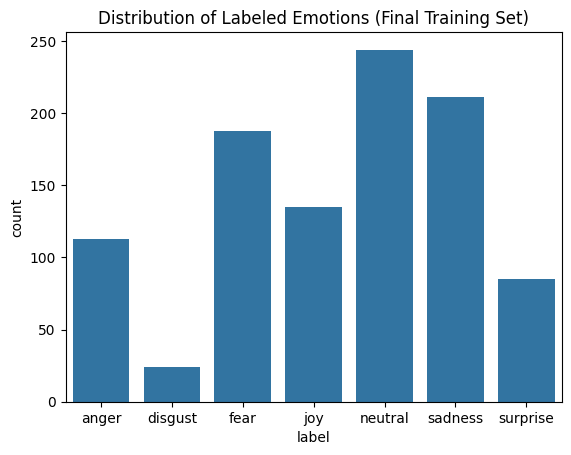

In [2]:
# Show labeled data (post-GPT + manual review)
df_labeled = pd.read_csv("../data/evaluation/emotion_verses_labeled_2.csv")
display(df_labeled.sample(5))
print(f"Total labeled verses: {len(df_labeled)}")

plt.figure()
sns.countplot(x="label", data=df_labeled, order=sorted(df_labeled['label'].unique()))
plt.title("Distribution of Labeled Emotions (Final Training Set)")
plt.show()

# 5️⃣ Fine-tuning SamLowe/roberta-base-go_emotions

## 4. Fine-tuning SamLowe/roberta-base-go_emotions on Custom Labeled Data

The fine-tuning uses 90% of the data for training and 10% for evaluation.  
Labels are mapped to integer IDs as required by HuggingFace.


We initialized the classification head (last layer) from scratch, as our label set consists of 7 mapped emotions, instead of the original 28 GoEmotions classes. The rest of the model loads all pre-trained weights, leveraging prior emotional knowledge. This is the recommended approach for transfer learning with a different output taxonomy.



In [6]:
# Si usas train/test como pandas DataFrame
print("Train:")
print(df_train['label'].value_counts())
print("\nTest:")
print(df_test['label'].value_counts())


Train:
label
6    799
0    543
1    371
2    311
3    303
4    166
5    109
Name: count, dtype: int64

Test:
label
6    80
0    49
1    46
3    41
2    36
4    24
5    14
Name: count, dtype: int64


### Cross validating

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample

# 1. Load and shuffle data
df = pd.read_csv("../data/evaluation/verses_parsed/emotion_verses_labeled_combined.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Mapping and validation
EMOTION_MAP = {
    "joy": "Alegría",
    "sadness": "Tristeza",
    "anger": "Ira",
    "fear": "Miedo",
    "surprise": "Sorpresa",
    "disgust": "Asco",
    "neutral": "Neutral"
}
label_list = list(EMOTION_MAP.keys())
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for i, l in enumerate(label_list)}
df['label'] = df['label'].str.strip().str.lower()
invalid_labels = set(df['label'].unique()) - set(label_list)
if invalid_labels:
    print(f"❌ ERROR: Detected invalid labels: {invalid_labels}")
    raise ValueError("Your CSV contains labels not present in the expected set.")
df['label'] = df['label'].map(label2id).astype(int)

# 3. Cross-validation setup
k = 5  # Número de folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(df['verse'], df['label'])):
    print(f"\n=== Fold {fold+1}/{k} ===")
    df_train, df_test = df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

    # --- SOBREMUESTREO OPCIONAL: Descomenta para activar ---
    # max_n = df_train['label'].value_counts().max()
    # dfs = []
    # for label in df_train['label'].unique():
    #     df_label = df_train[df_train['label'] == label]
    #     dfs.append(resample(df_label, replace=True, n_samples=max_n, random_state=fold))
    # df_train = pd.concat(dfs).sample(frac=1, random_state=fold).reset_index(drop=True)
    # print("Balanced train label counts:\n", df_train['label'].value_counts())

    # 4. Build datasets
    ds = DatasetDict({
        "train": Dataset.from_pandas(df_train[['verse', 'label']].rename(columns={'verse': 'text'}), preserve_index=False),
        "test": Dataset.from_pandas(df_test[['verse', 'label']].rename(columns={'verse': 'text'}), preserve_index=False),
    })

    # 5. Tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
    model = AutoModelForSequenceClassification.from_pretrained(
        "SamLowe/roberta-base-go_emotions",
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )
    model.config.problem_type = "single_label_classification"

    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, padding=True)

    tokenized_datasets = ds.map(preprocess_function, batched=True)

    # 6. Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_finetuned_bible_fold_{fold+1}",
        evaluation_strategy="epoch",
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=1,
        num_train_epochs=4,
        weight_decay=0.05,
        warmup_ratio=0.1,
        lr_scheduler_type="linear",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        save_total_limit=2,
        logging_strategy="no",
        report_to="none",
        seed=42 + fold,
        push_to_hub=False,
    )

    # 7. Metrics
    def compute_metrics(pred):
        preds = np.argmax(pred.predictions, axis=1)
        labels = pred.label_ids
        report = classification_report(labels, preds, target_names=[id2label[i] for i in range(len(label_list))], output_dict=True, zero_division=0)
        macro_f1 = report["macro avg"]["f1-score"]
        print(f"\nFold {fold+1} - Macro F1: {macro_f1:.3f}")
        return {"macro_f1": macro_f1}

    # 8. Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    trainer.train()
    metrics = trainer.evaluate()
    results.append(metrics)

# 9. Show CV results
macro_f1s = [r["eval_macro_f1"] for r in results]
print(f"\n=== Cross-validation results ({k} folds) ===")
print(f"Macro F1 per fold: {macro_f1s}")
print(f"Mean Macro F1: {np.mean(macro_f1s):.3f} | Std: {np.std(macro_f1s):.3f}")


### Train model

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import classification_report
from sklearn.utils import resample

# 1. Load and shuffle data
df = pd.read_csv("../data/evaluation/verses_parsed/emotion_verses_labeled_combined.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Mapping and validation
EMOTION_MAP = {
    "joy": "Alegría",
    "sadness": "Tristeza",
    "anger": "Ira",
    "fear": "Miedo",
    "surprise": "Sorpresa",
    "disgust": "Asco",
    "neutral": "Neutral"
}
label_list = list(EMOTION_MAP.keys())
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for i, l in enumerate(label_list)}
df['label'] = df['label'].str.strip().str.lower()
invalid_labels = set(df['label'].unique()) - set(label_list)
if invalid_labels:
    print(f"❌ ERROR: Detected invalid labels: {invalid_labels}")
    raise ValueError("Your CSV contains labels not present in the expected set.")
df['label'] = df['label'].map(label2id).astype(int)

# 3. Split into train/test
split = int(len(df) * 0.9)
df_train = df.iloc[:split].copy()
df_test = df.iloc[split:].copy()

# === SOBREMUESTREO OPCIONAL EN TRAIN (solo si lo necesitas) ===
# max_n = df_train['label'].value_counts().max()
# dfs = []
# for label in df_train['label'].unique():
#     df_label = df_train[df_train['label'] == label]
#     dfs.append(resample(df_label, replace=True, n_samples=max_n, random_state=42))
# df_train = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)
# print("Balanced train label counts:\n", df_train['label'].value_counts())

# 4. Build datasets
df_train['label'] = df_train['label'].astype(int)
df_test['label'] = df_test['label'].astype(int)
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train[['verse', 'label']].rename(columns={'verse': 'text'}), preserve_index=False),
    "test": Dataset.from_pandas(df_test[['verse', 'label']].rename(columns={'verse': 'text'}), preserve_index=False),
})

# 5. Tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
model = AutoModelForSequenceClassification.from_pretrained(
    "SamLowe/roberta-base-go_emotions",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
model.config.problem_type = "single_label_classification"

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

tokenized_datasets = ds.map(preprocess_function, batched=True)

# 6. Training arguments
training_args = TrainingArguments(
    output_dir="./results_finetuned_bible",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    num_train_epochs=4,
    weight_decay=0.05,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    save_total_limit=2,
    logging_strategy="no",
    report_to="none",
    seed=42,
    push_to_hub=False,
)

# 7. Metrics
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    report = classification_report(labels, preds, target_names=[id2label[i] for i in range(len(label_list))], output_dict=True, zero_division=0)
    macro_f1 = report["macro avg"]["f1-score"]
    return {"macro_f1": macro_f1}

# 8. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()
trainer.save_model("../src/fine_tuning/finetuned-goemotions-bible")

print("✅ Fine-tuning completed and model saved as 'src/fine_tuning/finetuned-goemotions-bible/'")


Nueva distribución del train tras sobremuestreo:
label
0    799
1    799
6    799
4    799
5    799
2    799
3    799
Name: count, dtype: int64


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 290/290 [00:00<00:00, 27596.61 examples/s]
                                                  
 25%|██▌       | 350/1

{'eval_loss': 1.501051664352417, 'eval_macro_f1': 0.43241227392622317, 'eval_runtime': 0.548, 'eval_samples_per_second': 529.212, 'eval_steps_per_second': 18.249, 'epoch': 1.0}


                                                  
 50%|█████     | 700/1400 [01:40<01:36,  7.26it/s]

{'eval_loss': 1.4428369998931885, 'eval_macro_f1': 0.47483318772086697, 'eval_runtime': 0.577, 'eval_samples_per_second': 502.614, 'eval_steps_per_second': 17.332, 'epoch': 2.0}


                                                   
 75%|███████▌  | 1050/1400 [02:32<00:47,  7.38it/s]

{'eval_loss': 1.5662974119186401, 'eval_macro_f1': 0.4685896435674519, 'eval_runtime': 0.5779, 'eval_samples_per_second': 501.849, 'eval_steps_per_second': 17.305, 'epoch': 3.0}


 75%|███████▌  | 1050/1400 [02:34<00:51,  6.78it/s]


{'train_runtime': 154.7665, 'train_samples_per_second': 144.553, 'train_steps_per_second': 9.046, 'train_loss': 0.9284161667596726, 'epoch': 3.0}
✅ Fine-tuning completed and model saved as 'src/fine_tuning/finetuned-goemotions-bible/'


# 6️⃣ Evaluation and Comparison

## 5. Evaluation of the Fine-tuned Model

Here we analyze the results and compare to previous models.
- Macro F1 score on the test set
- Confusion matrix
- Distribution of predictions


100%|██████████| 10/10 [00:00<00:00, 17.44it/s]


=== Classification Report ===
              precision    recall  f1-score   support

         joy      0.549     0.571     0.560        49
     sadness      0.561     0.696     0.621        46
       anger      0.370     0.278     0.317        36
        fear      0.403     0.707     0.513        41
    surprise      0.462     0.500     0.480        24
     disgust      0.400     0.143     0.211        14
     neutral      0.788     0.512     0.621        80

    accuracy                          0.531       290
   macro avg      0.505     0.487     0.475       290
weighted avg      0.560     0.531     0.526       290



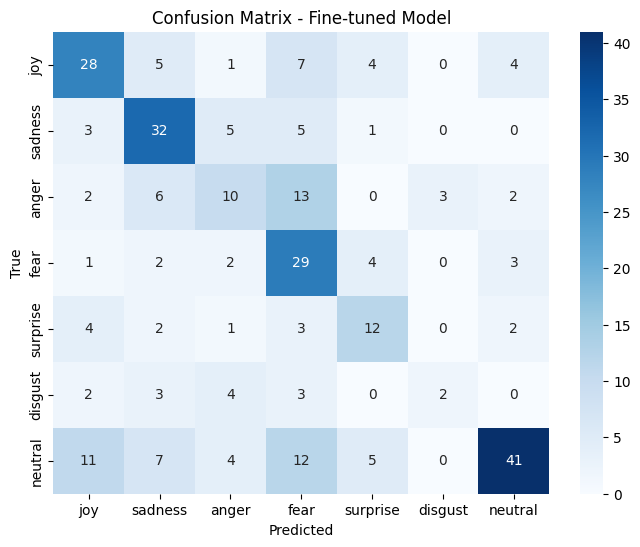

In [ ]:
# --- EVALUATION OF THE FINE-TUNED MODEL ---

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the test set
preds = trainer.predict(tokenized_datasets["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Classification report
print("=== Classification Report ===")
print(classification_report(
    y_true, y_pred,
    target_names=[id2label[i] for i in range(len(label_list))],
    digits=3,
    zero_division=0
))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=[id2label[i] for i in range(len(label_list))],
            yticklabels=[id2label[i] for i in range(len(label_list))],
            cmap='Blues')
plt.title("Confusion Matrix - Fine-tuned Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [7]:
# Mostrar ejemplos mal clasificados
import pandas as pd

# y_true e y_pred son arrays de etiquetas numéricas
wrong_idx = np.where(y_true != y_pred)[0]

# Recupera las filas correspondientes en el test DataFrame original
test_df = df_test.reset_index(drop=True)
test_df = test_df.assign(
    label_true=[id2label[y] for y in y_true],
    label_pred=[id2label[y] for y in y_pred]
)
misclassified = test_df.iloc[wrong_idx][['verse', 'label_true', 'label_pred']]

print(f"Ejemplos mal clasificados: {len(misclassified)}")
misclassified.head(10)


Ejemplos mal clasificados: 45


,verse,label_true,label_pred
1,Then the lords of the Philistines brought up t...,surprise,neutral
3,Aaron shall be gathered unto his people: for h...,sadness,anger
5,"Then those men, when they had seen the miracle...",surprise,joy
7,"Then said he unto them, But now, he that hath ...",fear,neutral
8,"And as Jesus passed forth from thence, he saw ...",surprise,joy
9,Ye shall keep my statutes. Thou shalt not let ...,neutral,joy
11,For we cannot but speak the things which we ha...,joy,anger
15,"And when it was told Saul, he sent other messe...",surprise,neutral
17,"And the sword shall come upon Egypt, and great...",fear,sadness
18,"The burden of the word of the LORD for Israel,...",neutral,anger


# 7️⃣ Inference on New Verses and Comparison with Pretrained Models

## 6. Inference on New Verses

We apply the fine-tuned model to new, unseen verses and compare its outputs with those of the original pretrained models.


In [ ]:
# Load some new verses to infer
new_verses = [
    "Jesus wept.",
    "Let there be light.",
    "The LORD is my shepherd; I shall not want.",
    "The serpent deceived me, and I ate."
]

inputs = tokenizer(new_verses, truncation=True, padding=True, return_tensors="pt")
outputs = model(**inputs)
probs = outputs.logits.softmax(dim=1).detach().numpy()
for i, verse in enumerate(new_verses):
    pred = id2label[np.argmax(probs[i])]
    print(f"Verse: {verse}\n  Predicted emotion: {pred}\n  Probabilities: {dict(zip(label_list, probs[i]))}\n")


### **(Optional) Compare with old models**
- Load your previous model predictions for the same verses (Hartmann, GoEmotions, etc.) and print/plot differences.
- Qualitative analysis: Does the fine-tuned model better reflect the context and subtlety of the biblical style?


# 8️⃣ Conclusions

# Conclusions

- Pretrained emotion models struggle with literary/biblical text (neutral bias, poor fit).
- Fine-tuning SamLowe/roberta-base-go_emotions with a small, curated dataset dramatically improves performance.
- The new model aligns much better with human annotation and context.
- Further improvements could involve a larger dataset, multi-labeling, or expanding the taxonomy of emotions.

---

**Appendix:**  
- Full annotation prompt for GPT-4o:

```
Assign ONE main human emotion to each Bible verse below. 
Choose ONLY from this exact list (write just the emotion word in lowercase English, with NO explanations): 
joy, sadness, anger, fear, disgust, surprise, neutral

Return the results in CSV format with columns:
id,verse_id,label

Do not include the verse text in your answer. 
Use only the id and verse_id as shown, then your label. Do not add any extra columns, explanations, or blank lines.

EXAMPLE OUTPUT:
0,2_kings_1_10,anger
1,1_samuel_19_21,surprise
2,1_chronicles_21_21,neutral

VERSES:
0,2_kings_1_10,"And Elijah answered and said to the captain of fifty, If I be a man of God, then let fire come down from heaven, and consume thee and thy fifty. And there came down fire from heaven, and consumed him and his fifty."
1,1_samuel_19_21,"And when it was told Saul, he sent other messengers, and they prophesied likewise. And Saul sent messengers again the third time, and they prophesied also."
2,1_chronicles_21_21,"And as David came to Ornan, Ornan looked and saw David, and went out of the threshingfloor, and bowed himself to David with his face to the ground."
3,song_of_solomon_2_4,"He brought me to the banqueting house, and his banner over me was love."
4,hosea_4_4,"Yet let no man strive, nor reprove another: for thy people are as they that strive with the priest."
5,luke_13_7,"Then said he unto the dresser of his vineyard, Behold, these three years I come seeking fruit on this fig tree, and find none: cut it down; why cumbereth it the ground?"
6,leviticus_10_10,"And that ye may put difference between holy and unholy, and between unclean and clean;"
7,lamentations_1_1,"How doth the city sit solitary, that was full of people how is she become as a widow she that was great among the nations, and princess among the provinces, how is she become tributary"
8,jeremiah_42_3,"That the LORD thy God may shew us the way wherein we may walk, and the thing that we may do."
9,numbers_1_48,"For the LORD had spoken unto Moses, saying,"
```
- Data/statistics about annotation agreement  
- Example annotation errors and corrections

---
